**Name:** SHUYUE JIA

**EID:** 56846018

# CS5489 - Tutorial 5
## Predicting Bike Sharing Usage

In this tutorial you will train a regression function to predict the number people using bike sharing in each day.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)

IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
random.seed(100)
import pandas as pd
import xgboost as xgb
from scipy import stats


## 1. Loading Data and Pre-processing
Next we need to load the data.  Download `Bike-Sharing-Dataset.zip`, and **unzip** it in the same directory as this ipynb file.  Then run the following cell to load the data.

In [2]:
# read the data
filename = 'Bike-Sharing-Dataset/day.csv'
df = pd.read_csv(filename)
print(df.shape)
df


(731, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Here are the columns in the dataset. The last 3 columns are the counts for the day.

In [3]:
df.columns


Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

Here is a description of the features:
- `instant`: record index
- `dteday`: date
- `season`: season (1: winter, 2:spring, 3:summer, 4:fall)
- `yr`: year (0: 2011, 1:2012)
- `mnth`: month (1=Jan to 12=Dec)
- `holiday`: weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- `weekday`: day of the week (1=Sunday to 7=Saturday)
- `workingday`: if day is neither weekend nor holiday is 1, otherwise is 0.
- `weathersit`: weather situation
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- `temp`: Normalized temperature in Celsius. The values are divided to 41 (max)
- `atemp`: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- `hum`: Normalized humidity. The values are divided to 100 (max)
- `windspeed`: Normalized wind speed. The values are divided to 67 (max)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes including both casual and registered

The first two columns are the instance number and date, which aren't useful, so we will remove them.

In [4]:
# remove first 2 columns
df.drop(columns=['instant', 'dteday'], inplace=True)
print(df.shape)


(731, 14)


Next we will examine the distribution of the features.

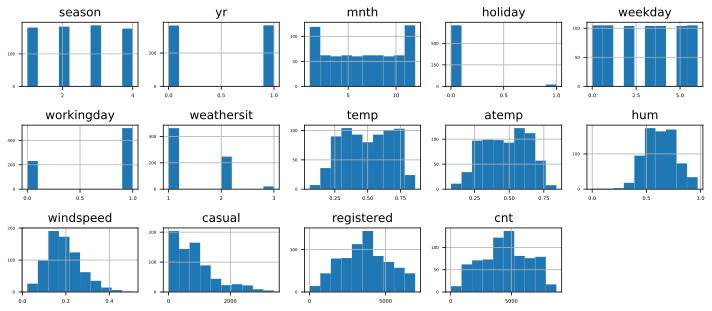

In [5]:
# show the feature distributions
foo = df.hist(layout=(14,5), figsize=(10,20), xlabelsize=5, ylabelsize=4)
plt.tight_layout()


And here are some simple statistics of the features.

In [6]:
df.describe()


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


You may notice that a few of the features are discrete values, such as `season`, `mnth`, `weekday`, and `weathersit`.  If we directly use the month feature, it may not make too much sense since adding/subtracting/multipllying 2 month numbers doesn't really mean anything related to the output. Instead, it is important which month it is.

Thus, we will convert these features into one-hot-encodings.  The original discrete features are removed, and the new features are appended to the end of the table.

In [7]:
# use pandas to create one-hot-encodings of a few colummns
dfd = pd.get_dummies(df, columns=['season', 'mnth', 'weekday', 'weathersit'])
print(dfd.shape)
dfd


(731, 36)


,yr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
0,0,0,0,0.344167,0.363625,0.805833,0.160446,331,654,985,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0.363478,0.353739,0.696087,0.248539,131,670,801,...,1,0,0,0,0,0,0,0,1,0
2,0,0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,...,0,1,0,0,0,0,0,1,0,0
3,0,0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,...,0,0,1,0,0,0,0,1,0,0
4,0,0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,0,1,0.254167,0.226642,0.652917,0.350133,247,1867,2114,...,0,0,0,0,1,0,0,0,1,0
727,1,0,1,0.253333,0.255046,0.590000,0.155471,644,2451,3095,...,0,0,0,0,0,1,0,0,1,0
728,1,0,0,0.253333,0.242400,0.752917,0.124383,159,1182,1341,...,0,0,0,0,0,0,1,0,1,0
729,1,0,0,0.255833,0.231700,0.483333,0.350754,364,1432,1796,...,1,0,0,0,0,0,0,1,0,0


Now we extract the data for running our regression algorithm. First we remove the counts to get the input features X.

In [8]:
# extract the features
dfX = dfd.drop(columns=['casual', 'registered', 'cnt'])
dataX = array(dfX)
dataX.shape


(731, 33)

In [9]:
# get the feature names
featnames = [x.strip() for x in dfX.columns]
print(featnames)


['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3']


Next we use the total count as the target Y.

In [10]:
# get the target count
dataY = array(dfd['cnt'])
dataY.shape


(731,)

Finally, we extract the year number, which we will use for setting up the training/testing data later.

In [11]:
# get the year number (used for splitting the data into training/testing)
dataYear = array(dfd['yr'])
dataYear.shape


(731,)

Here is an example input/output for our problem.

In [12]:
print(featnames)

print("--- example features---")
print(dataX[0], '\n')

print("--- example target count")
print(dataY[0])


['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed', 'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3']
--- example features---
[0.       0.       0.       0.344167 0.363625 0.805833 0.160446 1.
 0.       0.       0.       1.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       1.       0.       1.
 0.      ] 

--- example target count
985


Now we separate the data into training and testing sets.  Since our data is collected over time, it is better to separate the training and test data so that they don't overlap in time. This way, we can ensure that our method generalizes to newly collected data.

We will use the first year for training, and the second year for testing.

(731, 33)
(731,)
(365, 33)
(366, 33)
(365,)
(366,)


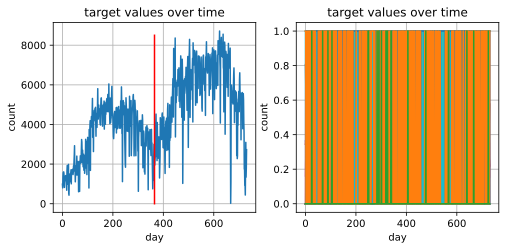

In [13]:
# use 1st year as training data
trainX = dataX[dataYear==0]
trainY = dataY[dataYear==0]

# use 2nd year as testing data
testX  = dataX[dataYear==1]
testY  = dataY[dataYear==1]


print(dataX.shape)
print(dataY.shape)

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plt.plot(dataY)
plt.plot([365,365], [0,8500], 'r')
plt.grid(True)
plt.xlabel('day')
plt.ylabel('count')
plt.title('target values over time');

plt.subplot(1,2,2)
plt.plot(dataX)
# plt.plot([365,365], [0,8500], 'r')
plt.grid(True)
plt.xlabel('day')
plt.ylabel('count')
plt.title('target values over time');


Note that the input features are already normalized between 0 and 1 (or are binary values), so we don't need to perform feature normalization.

### Dummy regressor
We next test a "dummy" regressor that simply predicts the mean or median output value.  These are useful to evaluate the regression methods to see how much better they are than simply predicting the same value.

In [14]:
# dummy regressors that predict constant values
dummy_mean = dummy.DummyRegressor(strategy='mean')
dummy_mean.fit(trainX, trainY)

dummy_med = dummy.DummyRegressor(strategy='median')
dummy_med.fit(trainX, trainY)


DummyRegressor(strategy='median')

Next we evaluate the regressor using MSE and MAE.

In [15]:
# function to evaluate root mean squared error (MSE) and mean absolute error (MAE)
def eval_predict(trueY, predY):
    MAE = metrics.mean_absolute_error(trueY, predY)
    RMSE = sqrt(metrics.mean_squared_error(trueY, predY))
    return RMSE, MAE

# function to make a scatter plot
def plot_scatter(testY, predY, titlestr):
    plt.scatter(testY, predY, s=1)
    plt.plot([min(testY),max(testY)], [min(testY),max(testY)], 'r-')
    plt.xlabel('true')
    plt.ylabel('prediction')
    r1,r2 = eval_predict(testY, predY)
    plt.title(titlestr + "\n(RMSE={:.3f}; MAE={:.3f})".format(r1,r2))
    plt.grid(True)


In [16]:
# place to store our regression results
trainerr={}; 
testerr={}

trainerr['dummy_mean'] = eval_predict(trainY, dummy_mean.predict(trainX))
testerr['dummy_mean']  = eval_predict(testY, dummy_mean.predict(testX))
trainerr['dummy_med']  = eval_predict(trainY, dummy_med.predict(trainX))
testerr['dummy_med']   = eval_predict(testY, dummy_med.predict(testX))

print("dummy-mean: train (RMSE,MAE)=", trainerr['dummy_mean'])
print("dummy-mean: test  (RMSE,MAE)=", testerr['dummy_mean'])
print("dummy-med:  train (RMSE,MAE)=", trainerr['dummy_med'])
print("dummy-med:  test  (RMSE,MAE)=", testerr['dummy_med'])

dummy-mean: train (RMSE,MAE)= (1376.8636667749531, 1197.7539801088385)
dummy-mean: test  (RMSE,MAE)= (2829.3083242385123, 2488.6733587843405)
dummy-med:  train (RMSE,MAE)= (1416.8517338156587, 1172.8849315068494)
dummy-med:  test  (RMSE,MAE)= (2578.749205425156, 2260.841530054645)


Finally, we can visualize the quality of the prediction result by using a scatter plot.  Since we are using a "dummy" predictor, the x-value predictions are constant.  The red line shows the ideal regressor where all the predictions are equal to the true values.

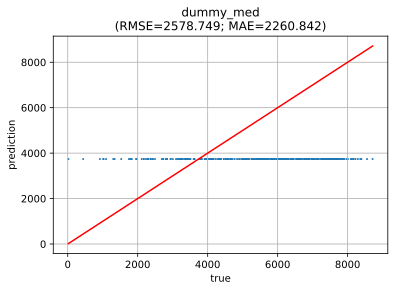

In [17]:
plot_scatter(testY, dummy_med.predict(testX), 'dummy_med')

## 2. Prediction with Linear Regression

First we will look at predicting the count using simple linear regression models.  Use the training data to fit a linear model using Ordinary Least Squares and Ridge Regression.  Use cross-validation on the training set to select the optimal $\alpha$ parameter for ridge regression.

In [18]:
# fit using ordinary least squares 
scaler = preprocessing.StandardScaler() 
trainXn = scaler.fit_transform(trainX) 
testXn = scaler.transform(testX)

ols = linear_model.LinearRegression() 
ols.fit(trainXn, trainY)

# place to store our regression results
trainerr = {}; 
testerr = {}

trainerr['LinearRegression'] = eval_predict(trainY, ols.predict(trainXn))
testerr['LinearRegression']  = eval_predict(testY, ols.predict(testXn))
print("Linear Regression: train (RMSE,MAE)=", trainerr['LinearRegression'] )
print("Linear Regression: test  (RMSE,MAE)=", testerr['LinearRegression']  )


Linear Regression: train (RMSE,MAE)= (549.2930828763455, 407.4419388185027)
Linear Regression: test  (RMSE,MAE)= (2301.19869380559, 2123.935765685022)


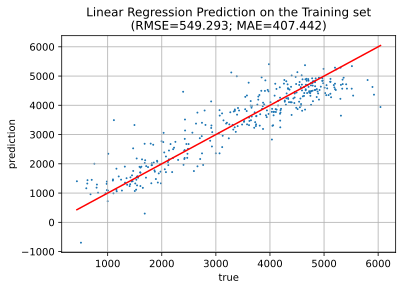

In [19]:
plot_scatter(trainY, ols.predict(trainXn), 'Linear Regression Prediction on the Training set')


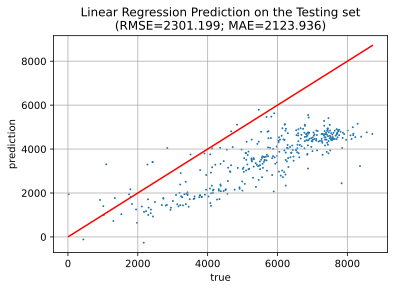

In [20]:
plot_scatter(testY, ols.predict(testXn), 'Linear Regression Prediction on the Testing set')


Compare the two models using the RMSE and MAE between the predictions and the true values.  Below is  code that will calculate evaluation for the training and test sets.

In [21]:
# Ridge Regression Model
# alpha values to try 
alphas = logspace(-3, 3, 100)
MSEs = empty(len(alphas))
ws = empty((len(alphas), trainXn.shape[1])) 

for i, alpha in enumerate(alphas):
    # learn the RR model 
    rr = linear_model.RidgeCV(alphas=alphas, cv=5) 
    rr.fit(trainXn, trainY)
    ws[i,:] = rr.coef_
    # MSEs[i] = metrics.mean_squared_error(testY, rr.predict(testXn))
    
trainerr['rr'] = eval_predict(trainY, rr.predict(trainXn))
testerr['rr']  = eval_predict(testY, rr.predict(testXn))
print("Ridge Regression Model: train MSE,MAE =", trainerr['rr'])
print("Ridge Regression Model: test MSE,MAE =", testerr['rr'])


Ridge Regression Model: train MSE,MAE = (550.0602605168101, 408.96402226741816)
Ridge Regression Model: test MSE,MAE = (2302.8368797512485, 2127.006927376039)


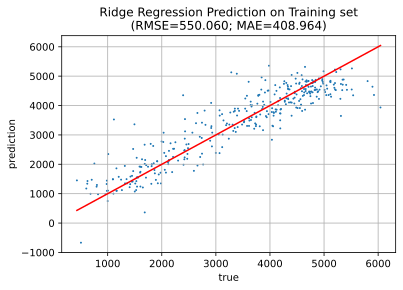

In [22]:
plot_scatter(trainY, rr.predict(trainXn), 'Ridge Regression Prediction on Training set')


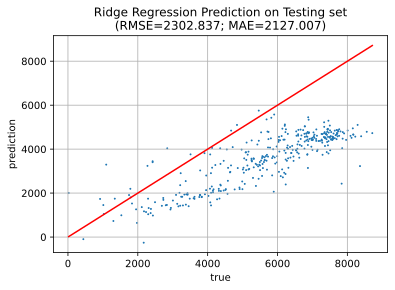

In [23]:
plot_scatter(testY, rr.predict(testXn), 'Ridge Regression Prediction on Testing set')


Which model has better prediction ability on the test set? Why?
- Although L2 norm has been used in the Ridge Regression Model to prevent overfitting, the performance of linear regression is better on this dataset (testing set). Typically, the results of Ridge Regression should be better.

Finally, we look at the scatter plot for ridge-regression.

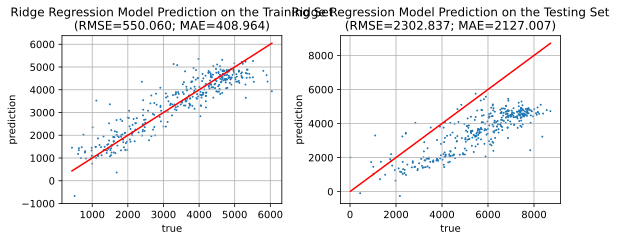

In [24]:
# Ridge Regression Model
plt.figure(figsize=(8,3.5))
plt.subplot(1,2,1)
plot_scatter(trainY, rr.predict(trainXn), "Ridge Regression Model Prediction on the Training Set")

plt.subplot(1,2,2)
plot_scatter(testY, rr.predict(testXn), "Ridge Regression Model Prediction on the Testing Set")
plt.tight_layout()


Do you notice anything interesting about the test predictions?  We'll see how to solve this problem later.

- 1. There is a overfitting problem shown in the testing set. 
- 2. The overall trend of the predictions is consistent the that of the testing labels. However, the prediction values really consistent with the training set labels rather than testing set labels.

# 3. Which features are important?
Next we will investigate which features are the most important for the prediction.  Use LASSO with cross-validation to learn the model.

In [25]:
# LASSO Model
lasalphas = logspace(-3,2,50)
lassoMSEs = empty(len(alphas))
lassows = empty((len(alphas), trainXn.shape[1]))

for i,alpha in enumerate(lasalphas):
    lasso = linear_model.LassoCV(cv=5) 
    lasso.fit(trainXn, trainY)
    
    lassows[i,:] = lasso.coef_
    lassoMSEs[i] = metrics.mean_squared_error(testY, lasso.predict(testXn))

trainerr['LASSO'] = eval_predict(trainY, lasso.predict(trainXn))
testerr['LASSO'] = eval_predict(testY, lasso.predict(testXn))
print("LASSO: train MSE, MAE =", trainerr['LASSO'])
print("LASSO: test MSE, MAE =", testerr['LASSO'])


LASSO: train MSE, MAE = (557.0594866278033, 420.8076186349962)
LASSO: test MSE, MAE = (2304.9384854860004, 2125.415692546614)


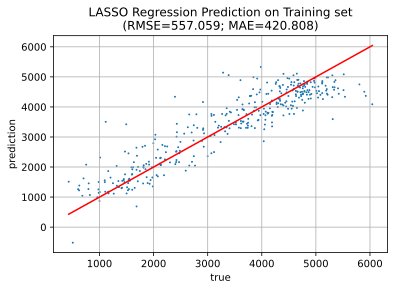

In [26]:
plot_scatter(trainY, lasso.predict(trainXn), 'LASSO Regression Prediction on Training set')


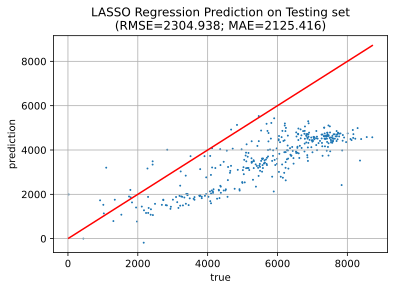

In [27]:
plot_scatter(testY, lasso.predict(testXn), 'LASSO Regression Prediction on Testing set')


Examine the LASSO coefficients by sorting them in descending order.

In [28]:
# sort coefficients from smallest to largest, then reverse it
inds = argsort(abs(lasso.coef_))[::-1]

# print out
print("weight : feature description")

for i in inds:
    print("{: .3f} : {}".format(lasso.coef_[i], featnames[i]))

print("bias = ", lasso.intercept_)


weight : feature description
 630.900 : temp
-374.137 : season_1
-256.381 : weathersit_3
 178.819 : mnth_5
-156.275 : hum
 144.254 : weathersit_1
-141.316 : windspeed
 121.258 : mnth_6
-120.892 : mnth_1
 112.308 : mnth_9
 110.952 : season_4
 96.097 : mnth_10
-71.416 : mnth_2
-64.180 : mnth_3
-50.348 : season_2
-47.683 : holiday
-21.862 : weekday_0
-11.646 : mnth_7
 9.937 : season_3
 3.239 : weekday_5
 0.431 : weekday_6
-0.000 : weekday_3
-0.000 : weekday_4
 0.000 : workingday
 0.000 : atemp
-0.000 : weekday_1
-0.000 : mnth_4
 0.000 : weekday_2
-0.000 : weathersit_2
 0.000 : mnth_8
 0.000 : mnth_11
-0.000 : mnth_12
 0.000 : yr
bias =  3405.7616438356176


_Which features have largest affect on the predicted bike share count, and what is the interpretation?_

Note that the features are normalized between 0 and 1 (or are binary values), so the weights corresponding to increase/decrease of bike count.  The bias term corresponds to the typical number of bikes used, which is modified based on the features.
- I found that the factors of temperature, winter and fall seasons, light snow, months, wind speed, holiday are quite essential to the usage of bikes. It also keep consistent with our common sense that when it is cold or the speed of wind is high, we are less likely to use a shared bikes. Otherwise, we might choose to use a bike.

Now try feature selection using OMP.  You can try the top 10 features.

In [29]:
omp = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=10) 
omp.fit(trainXn, trainY)

MSE = metrics.mean_squared_error(testY, omp.predict(testXn)) 
print("MSE =", MSE) 
print(omp.coef_)
print(omp.intercept_)

# sort coefficients from smallest to largest, then reverse it
inds = argsort(abs(omp.coef_))[::-1]

# print out
print("weight : feature description")

for i in inds:
    print("{: .3f} : {}".format(omp.coef_[i], featnames[i]))

print("bias = ", omp.intercept_)


MSE = 5239664.0354426615
[   0.            0.            0.            0.          737.92315986
 -188.39133781 -133.86528953 -390.20243115    0.            0.
  250.31436556    0.            0.            0.            0.
  192.93729946  135.0097957     0.            0.          156.39522257
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.         -142.36914255 -317.91460528]
3405.7616438356163
weight : feature description
 737.923 : atemp
-390.202 : season_1
-317.915 : weathersit_3
 250.314 : season_4
 192.937 : mnth_5
-188.391 : hum
 156.395 : mnth_9
-142.369 : weathersit_2
 135.010 : mnth_6
-133.865 : windspeed
 0.000 : weekday_0
 0.000 : mnth_12
 0.000 : holiday
 0.000 : workingday
 0.000 : temp
 0.000 : weathersit_1
 0.000 : weekday_6
 0.000 : weekday_5
 0.000 : season_2
 0.000 : season_3
 0.000 : weekday_4
 0.000 : mnth_1
 0.000 : mnth_2
 0.000 : mnth_3
 0.000 : mnth_4
 0.000 : weekday_3
 0.000 : 

Do you get similar selected features? Why or why not?
- Yes! The results of features are quite similar with them produced by the LASSO model.

# 4. Non-linear Regression
Now use non-linear regression to try to improve the prediction accuracy.  
Use cross-validation on the training set to select the parameters. 

In [30]:
polyfeats = {} 
plin = {} 

for d in [1, 2, 3, 4, 5]:
    MSE_train = {}
    
    # extract polynomial features with degree d 
    polyfeats[d] = preprocessing.PolynomialFeatures(degree=d) 
    polyXf = polyfeats[d].fit_transform(trainXn) 
    
    # fit the parameters
    plin[d] = linear_model.LinearRegression() 
    plin[d].fit(polyXf, trainY)

    # calculate mean-square error on training set 
    MSE_train[d] = metrics.mean_squared_error(trainY, plin[d].predict(polyXf))
    print(MSE_train)
    

{1: 417976.7808219178}
{2: 44203.39589041096}
{3: 1.0804607665874794e-22}
{4: 6.116363247508323e-23}
{5: 5.201633215704413e-22}


In [31]:
# polyfeats[2] = preprocessing.PolynomialFeatures(degree=2) 

polytrainXf = polyfeats[3].fit_transform(trainXn) 
trainMSE = metrics.mean_squared_error(trainY, plin[3].predict(polytrainXf))

polytestXf = polyfeats[3].fit_transform(testXn) 
testMSE = metrics.mean_squared_error(testY, plin[3].predict(polytestXf))

print(trainMSE, '\n', testMSE)


1.0804607665874794e-22 
 5304431.975133358


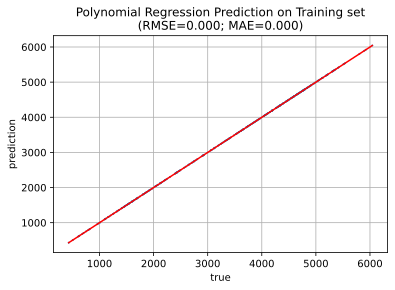

In [32]:
polytrainXf = polyfeats[3].fit_transform(trainXn)
plot_scatter(trainY, plin[3].predict(polytrainXf), 'Polynomial Regression Prediction on Training set')


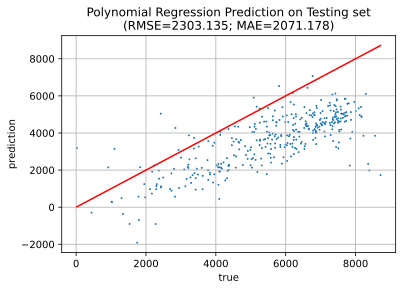

In [33]:
polytestXf = polyfeats[3].fit_transform(testXn)
plot_scatter(testY, plin[3].predict(polytestXf), 'Polynomial Regression Prediction on Testing set')


In [34]:
# make the pipeline 
polylin = pipeline.Pipeline([('polyfeats', preprocessing.PolynomialFeatures(degree=3)), 
                             ('linreg', linear_model.LinearRegression())])

# set the parameters for grid search 
paramgrid = {"polyfeats__degree": array([1, 2, 3, 4, 5])}

# do the cross-validdation search - use -MSE as the score for maximizing 
plincv = model_selection.GridSearchCV(polylin, 
                                      paramgrid, 
                                      cv=5,
                                      n_jobs=-1,
                                      scoring='neg_mean_squared_error')

plincv.fit(trainXn, trainY)
print(plincv.best_params_)


{'polyfeats__degree': 3}


Make a scatter plot of the best regressor. Call it `bestr`.

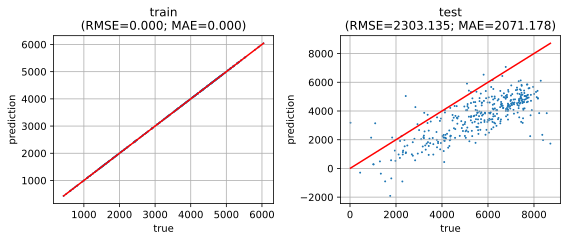

In [35]:
# scatter plot of the best regressor
plt.figure(figsize=(8, 3.5))
plt.subplot(1,2,1)
plot_scatter(trainY, plincv.predict(trainXn), "train")

plt.subplot(1,2,2)
plot_scatter(testY, plincv.predict(testXn), "test")
plt.tight_layout()


_Which regression method performs the best? Why do you think so?_
- **INSERT YOUR ANSWER HERE**

# 5. Test set bias

In your scatter plot above, you may have noticed that the regressor is almost always under-predicting the count (the points are usually below the red line). This suggests that there is some bias in the test set.

Let's look at the plot of the count over time.  The left side is the training data (1st year), and the right side is the testing data (2nd year)

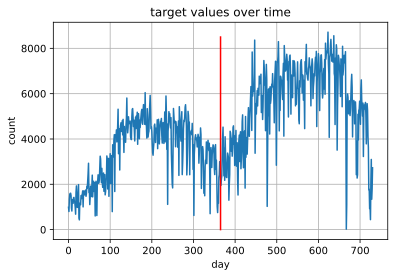

In [36]:
plt.plot(dataY)
plt.plot([365,365], [0,8500], 'r')
plt.grid(True)
plt.xlabel('day')
plt.ylabel('count')
plt.title('target values over time');

Interestingly, it looks like bike sharing became more popular in the 2nd year, so the overall counts are higher (but the seasonal trend looks the same).

Let's assume that we noticed this upward trend in the first 3 months of the year, and collected the data for training.  We will then use the remaining part of the 2nd year for testing.

In [37]:
# get indices for month 1 to month 3
print(featnames[11], featnames[12], featnames[13])
inds = (testX[:,11].ravel()==1) + (testX[:,12].ravel()==1) + (testX[:,13].ravel()==1)

# new training data from 2nd year (months 1-3)
trainX2 = testX[inds]
trainY2 = testY[inds]

# new testing data from 2nd year (months 4-12)
testX2 = testX[logical_not(inds)]
testY2 = testY[logical_not(inds)]
print(trainX2.shape)
print(testX2.shape)


mnth_1 mnth_2 mnth_3
(91, 33)
(275, 33)


There are several approaches for using the new data:
1. use the new data to train the regressor, and ignore the old data.
2. append the new data with the old data and train a regressor.  Note that we kept the "year" feature, so the regressor can distinguish the new and old training data.
3. use the new data to train a regressor on the residual error of the old regressor.  The residual error is the difference between the predicted count and true count on the new training data.

Using **one selected** regression method, try each of the approaches above to use the new data. You should compare the 3 approaches with the regressor trained on the original data and tested on the new test set (`testY2`).

In [38]:
# use the new data to train the regressor, and ignore the old data.

In [39]:
# append new data with old data
trainY2_append = trainY2
trainX2_append = trainX2

print(trainY2_append.shape)
print(trainX2_append.shape)


(91,)
(91, 33)


In [40]:
# Linear Regression Model
ols = linear_model.LinearRegression() 
ols.fit(trainX2_append, trainY2_append)

# place to store our regression results
trainerr = {}; 
testerr = {}

trainerr['LinearRegression'] = eval_predict(trainY2_append, ols.predict(trainX2_append))
testerr['LinearRegression']  = eval_predict(testY2, ols.predict(testX2))

print("LinearRegression: train (RMSE,MAE)=", trainerr['LinearRegression'] )
print("LinearRegression: test  (RMSE,MAE)=", testerr['LinearRegression']  )


LinearRegression: train (RMSE,MAE)= (559.4215705724528, 381.0878517427201)
LinearRegression: test  (RMSE,MAE)= (1316.511305493695, 1067.3690980363772)


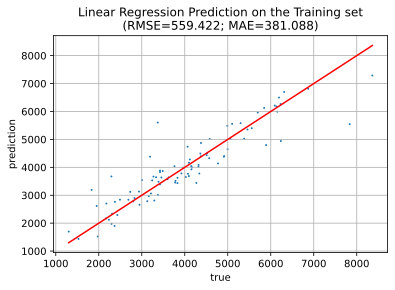

In [41]:
plot_scatter(trainY2_append, ols.predict(trainX2_append), 'Linear Regression Prediction on the Training set')


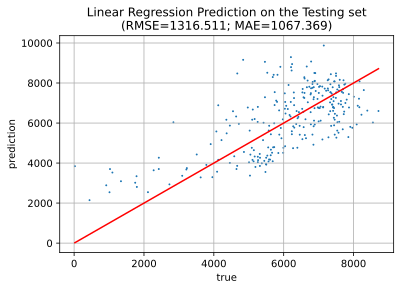

In [42]:
plot_scatter(testY2, ols.predict(testX2), 'Linear Regression Prediction on the Testing set')


In [43]:
# Ridge Regression Model
# normalize feature values to zero mean and unit variance
scaler = preprocessing.StandardScaler() 
trainX2n = scaler.fit_transform(trainX2_append) 
testX2n = scaler.transform(testX2)

print(trainX2n.shape) 
print(testX2n.shape)

# alpha values to try 
alphas = logspace(-6, 6, 100)
MSEs = empty(len(alphas))
ws = empty((len(alphas), trainXn.shape[1])) 

for i, alpha in enumerate(alphas):
    # learn the RR model 
    rr = linear_model.RidgeCV(alphas=alphas, cv=5) 
    rr.fit(trainX2n, trainY2_append)
    
    ws[i,:] = rr.coef_
    MSEs[i] = metrics.mean_squared_error(testY2, rr.predict(testX2n))

trainerr['rr'] = eval_predict(trainY2_append, rr.predict(trainX2n))
testerr['rr']  = eval_predict(testY2, rr.predict(testX2n))

print("RR: train MSE,MAE =", trainerr['rr'])
print("RR: test  MSE,MAE =", testerr['rr'])


(91, 33)
(275, 33)
RR: train MSE,MAE = (570.4038547450789, 370.164323216183)
RR: test  MSE,MAE = (1209.6711928640361, 978.648551028319)


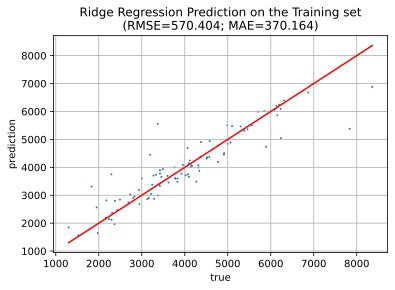

In [44]:
plot_scatter(trainY2_append, rr.predict(trainX2n), 'Ridge Regression Prediction on the Training set')


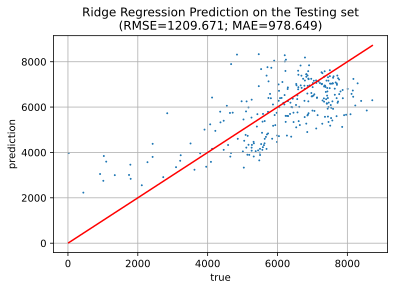

In [45]:
plot_scatter(testY2, rr.predict(testX2n), 'Ridge Regression Prediction on the Testing set')


In [46]:
# LASSO Model
lasalphas = logspace(-3,2,50)

lassoMSEs = empty(len(alphas))
lassows = empty((len(alphas), trainXn.shape[1]))

for i,alpha in enumerate(lasalphas):
    lasso = linear_model.LassoCV(cv=5) 
    lasso.fit(trainX2n, trainY2_append)
    
    lassows[i,:] = lasso.coef_
    lassoMSEs[i] = metrics.mean_squared_error(testY2, lasso.predict(testX2n))

trainerr['LASSO'] = eval_predict(trainY2_append, lasso.predict(trainX2n))
testerr['LASSO']  = eval_predict(testY2, lasso.predict(testX2n))

print("LASSO: train MSE, MAE =", trainerr['LASSO'])
print("LASSO: test MSE, MAE =", testerr['LASSO'])


LASSO: train MSE, MAE = (562.2566517599599, 376.0871451606566)
LASSO: test MSE, MAE = (1247.3357227440658, 1010.2543763159666)


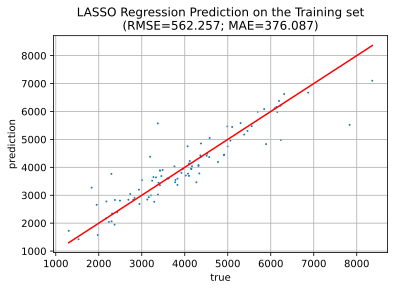

In [47]:
plot_scatter(trainY2_append, lasso.predict(trainX2n), 'LASSO Regression Prediction on the Training set')


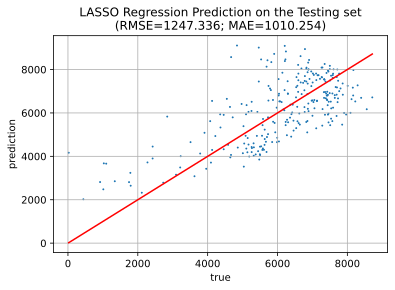

In [48]:
plot_scatter(testY2, lasso.predict(testX2n), 'LASSO Regression Prediction on the Testing set')


In [49]:
polyfeats = {} 
plin = {} 

for d in [1, 2, 3, 4, 5]:
    MSE_train = {}
    MSE_test = {}
    
    # extract polynomial features with degree d 
    polyfeats[d] = preprocessing.PolynomialFeatures(degree=d) 
    polyXf = polyfeats[d].fit_transform(trainX2n) 
    
    # fit the parameters 
    plin[d] = linear_model.LinearRegression() 
    plin[d].fit(polyXf, trainY2_append) 
    
    # calculate mean-square error on training set 
    MSE_train[d] = metrics.mean_squared_error(trainY2_append, plin[d].predict(polyXf))
    print(MSE_train)
    

{1: 312952.4936217498}
{2: 8.58787888225684e-22}
{3: 1.3638026725757528e-22}
{4: 2.4448868286467746e-22}
{5: 6.710644748974581e-22}


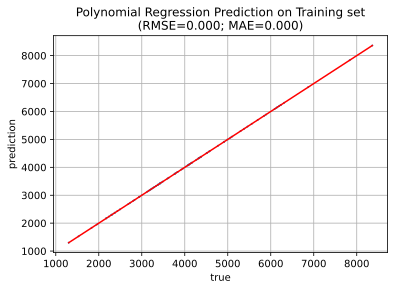

In [50]:
polytrainXf = polyfeats[3].fit_transform(trainX2n)
plot_scatter(trainY2_append, plin[3].predict(polytrainXf), 'Polynomial Regression Prediction on Training set')


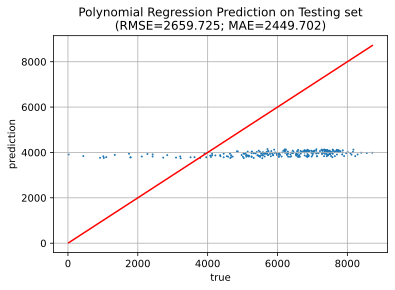

In [51]:
polytestXf = polyfeats[3].fit_transform(testX2)
plot_scatter(testY2, plin[3].predict(polytestXf), 'Polynomial Regression Prediction on Testing set')


In [52]:
# append new data (1 - 3 month of Year Two) with old data (Year One data)

# use 1st year as training data
trainX = dataX[dataYear==0]
trainY = dataY[dataYear==0]
trainY2_append = concatenate((trainY, trainY2), axis=0)
trainX2_append = concatenate((trainX, trainX2), axis=0)

print(trainY2_append.shape)
print(trainX2_append.shape)


(456,)
(456, 33)


In [53]:
# Linear Regression Model
ols = linear_model.LinearRegression() 
ols.fit(trainX2_append, trainY2_append)

# place to store our regression results
trainerr = {}; 
testerr = {}

trainerr['LinearRegression'] = eval_predict(trainY2_append, ols.predict(trainX2_append))
testerr['LinearRegression']  = eval_predict(testY2, ols.predict(testX2))

print("LinearRegression: train (RMSE,MAE)=", trainerr['LinearRegression'] )
print("LinearRegression: test  (RMSE,MAE)=", testerr['LinearRegression']  )


LinearRegression: train (RMSE,MAE)= (599.2164426034625, 437.38157894736844)
LinearRegression: test  (RMSE,MAE)= (1041.4384861664898, 816.5184090909091)


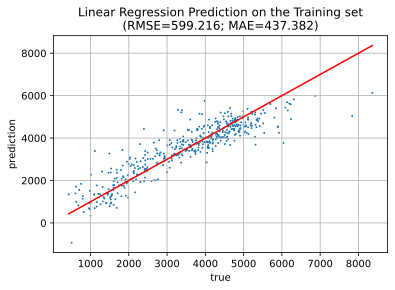

In [54]:
plot_scatter(trainY2_append, ols.predict(trainX2_append), 'Linear Regression Prediction on the Training set')


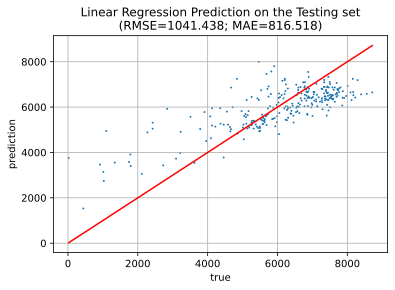

In [55]:
plot_scatter(testY2, ols.predict(testX2), 'Linear Regression Prediction on the Testing set')


In [56]:
# Ridge Regression Model
# normalize feature values to zero mean and unit variance
scaler = preprocessing.StandardScaler() 
trainX2n = scaler.fit_transform(trainX2_append) 
testX2n = scaler.transform(testX2)

print(trainX2n.shape) 
print(testX2n.shape)

# alpha values to try 
alphas = logspace(-6, 6, 100)
MSEs = empty(len(alphas))
ws = empty((len(alphas), trainXn.shape[1])) 

for i, alpha in enumerate(alphas):
    # learn the RR model 
    rr = linear_model.RidgeCV(alphas=alphas, cv=5) 
    rr.fit(trainX2n, trainY2_append)
    
    ws[i,:] = rr.coef_
    MSEs[i] = metrics.mean_squared_error(testY2, rr.predict(testX2n))

trainerr['rr'] = eval_predict(trainY2_append, rr.predict(trainX2n))
testerr['rr']  = eval_predict(testY2, rr.predict(testX2n))

print("RR: train MSE,MAE =", trainerr['rr'])
print("RR: test  MSE,MAE =", testerr['rr'])


(456, 33)
(275, 33)
RR: train MSE,MAE = (599.2156301941824, 437.37678983334195)
RR: test  MSE,MAE = (1041.2560327193773, 816.1799250892913)


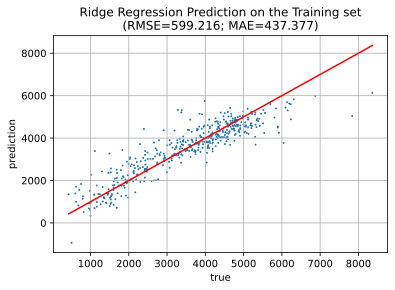

In [57]:
plot_scatter(trainY2_append, rr.predict(trainX2n), 'Ridge Regression Prediction on the Training set')


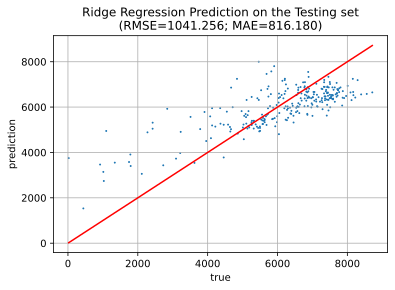

In [58]:
plot_scatter(testY2, rr.predict(testX2n), 'Ridge Regression Prediction on the Testing set')


In [59]:
# LASSO Model
lasalphas = logspace(-3,2,50)

lassoMSEs = empty(len(alphas))
lassows = empty((len(alphas), trainXn.shape[1]))

for i,alpha in enumerate(lasalphas):
    lasso = linear_model.LassoCV(cv=5) 
    lasso.fit(trainX2n, trainY2_append)
    
    lassows[i,:] = lasso.coef_
    lassoMSEs[i] = metrics.mean_squared_error(testY2, lasso.predict(testX2n))

trainerr['LASSO'] = eval_predict(trainY2_append, lasso.predict(trainX2n))
testerr['LASSO']  = eval_predict(testY2, lasso.predict(testX2n))

print("LASSO: train MSE, MAE =", trainerr['LASSO'])
print("LASSO: test MSE, MAE =", testerr['LASSO'])


LASSO: train MSE, MAE = (600.6419385378231, 440.3986046472724)
LASSO: test MSE, MAE = (1047.6135458718188, 826.9276825008334)


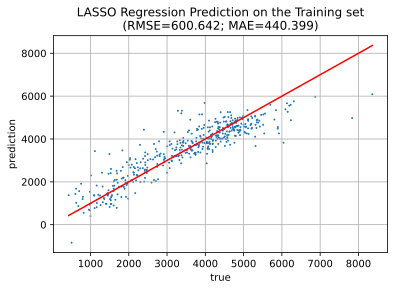

In [60]:
plot_scatter(trainY2_append, lasso.predict(trainX2n), 'LASSO Regression Prediction on the Training set')


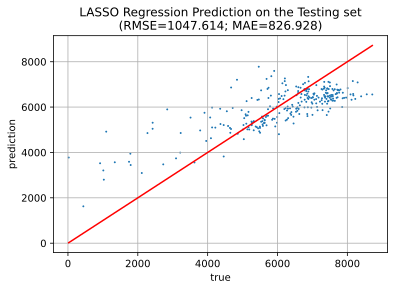

In [61]:
plot_scatter(testY2, lasso.predict(testX2n), 'LASSO Regression Prediction on the Testing set')


In [62]:
polyfeats = {} 
plin = {} 

for d in [1, 2, 3, 4, 5]:
    MSE_train = {}
    MSE_test = {}
    
    # extract polynomial features with degree d 
    polyfeats[d] = preprocessing.PolynomialFeatures(degree=d) 
    polyXf = polyfeats[d].fit_transform(trainX2n) 
    
    # fit the parameters 
    plin[d] = linear_model.LinearRegression() 
    plin[d].fit(polyXf, trainY2_append) 
    
    # calculate mean-square error on training set 
    MSE_train[d] = metrics.mean_squared_error(trainY2_append, plin[d].predict(polyXf))
    print(MSE_train)
    

{1: 364513.37673347123}
{2: 83861.71357593202}
{3: 2.8476849007402236e-23}
{4: 2.2422410713869063e-22}
{5: 5.096464281601628e-22}


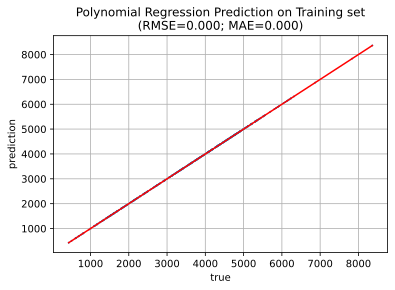

In [63]:
polytrainXf = polyfeats[3].fit_transform(trainX2n)
plot_scatter(trainY2_append, plin[3].predict(polytrainXf), 'Polynomial Regression Prediction on Training set')


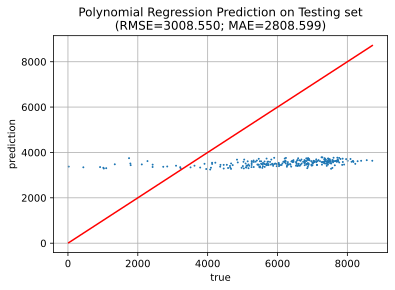

In [64]:
polytestXf = polyfeats[3].fit_transform(testX2)
plot_scatter(testY2, plin[3].predict(polytestXf), 'Polynomial Regression Prediction on Testing set')


In [65]:
# use the new data to train a regressor on the residual error of the old regressor. 
# The residual error is the difference between the predicted count and true count on the new training data.


In [66]:
# In this problem, I choose to use the Linear Regression Residual as the target

In [67]:
# use 1st year as training data
trainX = dataX[dataYear==0]
trainY = dataY[dataYear==0]
trainY2_append = concatenate((trainY, trainY2), axis=0)
trainX2_append = concatenate((trainX, trainX2), axis=0)

# Linear Regression Model
ols = linear_model.LinearRegression() 
ols.fit(trainX2_append, trainY2_append)

# New data
trainY2_append = trainY2_append - ols.predict(trainX2_append)
testY2 = testY2 - ols.predict(testX2)


In [68]:
# Linear Regression Model
ols = linear_model.LinearRegression() 
ols.fit(trainX2_append, trainY2_append)

# place to store our regression results
trainerr = {}; 
testerr = {}

trainerr['LinearRegression'] = eval_predict(trainY2_append, ols.predict(trainX2_append))
testerr['LinearRegression']  = eval_predict(testY2, ols.predict(testX2))

print("LinearRegression: train (RMSE,MAE)=", trainerr['LinearRegression'] )
print("LinearRegression: test  (RMSE,MAE)=", testerr['LinearRegression']  )


LinearRegression: train (RMSE,MAE)= (599.2171625945373, 437.3871984649123)
LinearRegression: test  (RMSE,MAE)= (1041.4029800859118, 816.4727272727273)


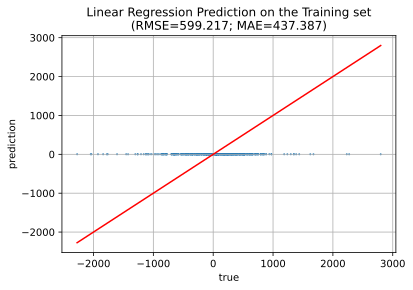

In [69]:
plot_scatter(trainY2_append, ols.predict(trainX2_append), 'Linear Regression Prediction on the Training set')


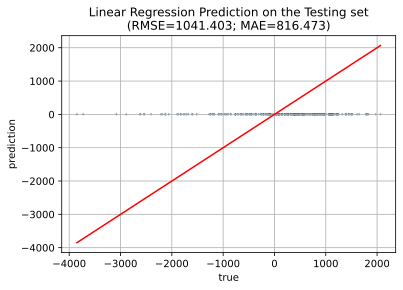

In [70]:
plot_scatter(testY2, ols.predict(testX2), 'Linear Regression Prediction on the Testing set')


In [71]:
# Ridge Regression Model
# normalize feature values to zero mean and unit variance
scaler = preprocessing.StandardScaler() 
trainX2n = scaler.fit_transform(trainX2_append) 
testX2n = scaler.transform(testX2)

print(trainX2n.shape) 
print(testX2n.shape)

# alpha values to try 
alphas = logspace(-6, 6, 100)
MSEs = empty(len(alphas))
ws = empty((len(alphas), trainXn.shape[1])) 

for i, alpha in enumerate(alphas):
    # learn the RR model 
    rr = linear_model.RidgeCV(alphas=alphas, cv=5) 
    rr.fit(trainX2n, trainY2_append)
    
    ws[i,:] = rr.coef_
    MSEs[i] = metrics.mean_squared_error(testY2, rr.predict(testX2n))

trainerr['rr'] = eval_predict(trainY2_append, rr.predict(trainX2n))
testerr['rr']  = eval_predict(testY2, rr.predict(testX2n))

print("RR: train MSE,MAE =", trainerr['rr'])
print("RR: test  MSE,MAE =", testerr['rr'])


(456, 33)
(275, 33)
RR: train MSE,MAE = (599.2164409887424, 437.38212808584217)
RR: test  MSE,MAE = (1041.4394566530748, 816.5210361076192)


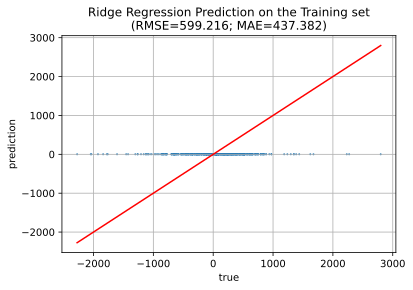

In [72]:
plot_scatter(trainY2_append, rr.predict(trainX2n), 'Ridge Regression Prediction on the Training set')


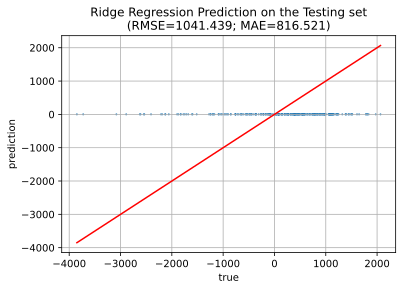

In [73]:
plot_scatter(testY2, rr.predict(testX2n), 'Ridge Regression Prediction on the Testing set')


In [74]:
# LASSO Model
lasalphas = logspace(-3,2,50)

lassoMSEs = empty(len(alphas))
lassows = empty((len(alphas), trainXn.shape[1]))

for i,alpha in enumerate(lasalphas):
    lasso = linear_model.LassoCV(cv=5) 
    lasso.fit(trainX2n, trainY2_append)
    
    lassows[i,:] = lasso.coef_
    lassoMSEs[i] = metrics.mean_squared_error(testY2, lasso.predict(testX2n))

trainerr['LASSO'] = eval_predict(trainY2_append, lasso.predict(trainX2n))
testerr['LASSO']  = eval_predict(testY2, lasso.predict(testX2n))

print("LASSO: train MSE, MAE =", trainerr['LASSO'])
print("LASSO: test MSE, MAE =", testerr['LASSO'])


LASSO: train MSE, MAE = (599.2164425351807, 437.38213440674053)
LASSO: test MSE, MAE = (1041.4395631194116, 816.5212051435408)


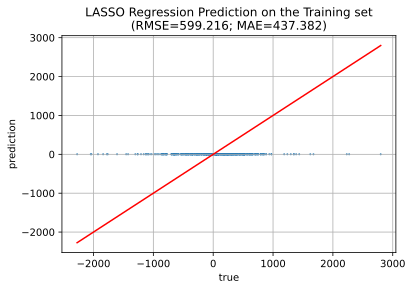

In [75]:
plot_scatter(trainY2_append, lasso.predict(trainX2n), 'LASSO Regression Prediction on the Training set')


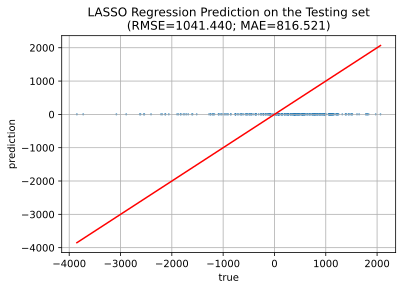

In [76]:
plot_scatter(testY2, lasso.predict(testX2n), 'LASSO Regression Prediction on the Testing set')


In [77]:
polyfeats = {} 
plin = {} 

for d in [1, 2, 3, 4, 5]:
    MSE_train = {}
    MSE_test = {}
    
    # extract polynomial features with degree d 
    polyfeats[d] = preprocessing.PolynomialFeatures(degree=d) 
    polyXf = polyfeats[d].fit_transform(trainX2n) 
    
    # fit the parameters 
    plin[d] = linear_model.LinearRegression() 
    plin[d].fit(polyXf, trainY2_append) 
    
    # calculate mean-square error on training set 
    MSE_train[d] = metrics.mean_squared_error(trainY2_append, plin[d].predict(polyXf))
    print(MSE_train)
    

{1: 364515.58246217424}
{2: 85266.31051260965}
{3: 1.8249270139144822e-23}
{4: 5.165443138320556e-23}
{5: 1.3961127066146475e-22}


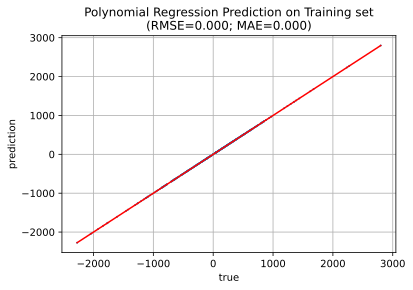

In [78]:
polytrainXf = polyfeats[3].fit_transform(trainX2n)
plot_scatter(trainY2_append, plin[3].predict(polytrainXf), 'Polynomial Regression Prediction on Training set')


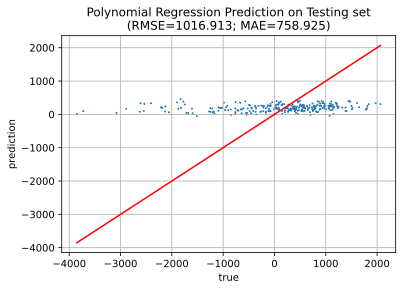

In [79]:
polytestXf = polyfeats[3].fit_transform(testX2)
plot_scatter(testY2, plin[3].predict(polytestXf), 'Polynomial Regression Prediction on Testing set')


_Which approach for using the new data is better? Explain why you think the other approaches don't work well._
- Adding part of the Year 2 data can result in better performance. However, since the internal time-series data keeps a high correlation, it may lead to the problem of overfitting. I mean, if there is data in Year Three, the trained model might not work well.